In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# 'cs231n' folder containing the '.py', 'classifiers' and 'datasets'
# folders.
# e.g. 'cs231n/assignments/assignment1/cs231n/'
FOLDERNAME = None

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../
%cd ../../
%cd cs231n/datasets/
!bash get_datasets.sh
%cd ../../

# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [13]:
from cs231n.classifiers.linear_classifier import LinearSVM

def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs and outputs are the same as svm_loss_naive.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero
    num_train = X.shape[0]
    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss.                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    scores = X.dot(W)
    yi_scores = scores[np.arange(scores.shape[0]),y]
    margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
    margins[np.arange(num_train),y] = 0
    loss = np.mean(np.sum(margins, axis=1))
    loss += reg * np.sum(W * W)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO:                                                                     #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    margins[margins > 0] = 1
    row_sum = np.sum(margins, axis=1)
    margins[np.arange(num_train), y] = -row_sum.T
    dW = np.dot(X.T, margins)/num_train
    dW += reg*W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # sampling without replacement is slower but converges faster
            indices = np.random.choice(np.arange(num_train),batch_size, False)
            X_batch = X[indices]
            y_batch = y[indices] 

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.W -= learning_rate*grad

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

def predict(self, X):
    """
    Use the trained weights of this linear classifier to predict labels for
    data points.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
        training samples each of dimension D.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
        array of length N, and each element is an integer giving the predicted
        class.
    """
    y_pred = np.zeros(X.shape[0])
    ###########################################################################
    # TODO:                                                                   #
    # Implement this method. Store the predicted labels in y_pred.            #
    ###########################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    y_pred = np.argmax(X@self.W,1)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return y_pred

def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)
# attach methods to class

setattr(LinearSVM, "train", train)
setattr(LinearSVM, "predict", predict)
setattr(LinearSVM, "loss", loss)

In [18]:
# Use the validation set to tune the learning rate and regularization strength

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = np.logspace(-7, -5, 10)
regularization_strengths = np.logspace(4,6,10)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
num_iters = 3
for lr in learning_rates:
    for rs in regularization_strengths:
        train_acc = []
        val_acc = []
        for i in range(num_iters):
            cls = LinearSVM()
            cls.train(X_train_feats, y_train, lr, rs)
            train_preds = cls.predict(X_train_feats)
            val_preds = cls.predict(X_val_feats)
            train_acc.append(np.mean(y_train == train_preds))
            val_acc.append(np.mean(y_val == val_preds))
        train_acc = np.mean(train_acc)
        val_acc = np.mean(val_acc)
        results[(lr,rs)] = (train_acc,val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = cls


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.095497 val accuracy: 0.094000
lr 1.000000e-07 reg 1.668101e+04 train accuracy: 0.113605 val accuracy: 0.116333
lr 1.000000e-07 reg 2.782559e+04 train accuracy: 0.104925 val accuracy: 0.107667
lr 1.000000e-07 reg 4.641589e+04 train accuracy: 0.106048 val accuracy: 0.104667
lr 1.000000e-07 reg 7.742637e+04 train accuracy: 0.109000 val accuracy: 0.111333
lr 1.000000e-07 reg 1.291550e+05 train accuracy: 0.096429 val accuracy: 0.094000
lr 1.000000e-07 reg 2.154435e+05 train accuracy: 0.111748 val accuracy: 0.109667
lr 1.000000e-07 reg 3.593814e+05 train accuracy: 0.105286 val accuracy: 0.094333
lr 1.000000e-07 reg 5.994843e+05 train accuracy: 0.184959 val accuracy: 0.198000
lr 1.000000e-07 reg 1.000000e+06 train accuracy: 0.405116 val accuracy: 0.398000
lr 1.668101e-07 reg 1.000000e+04 train accuracy: 0.092755 val accuracy: 0.093667
lr 1.668101e-07 reg 1.668101e+04 train accuracy: 0.107980 val accuracy: 0.104667
lr 1.668101e-07 reg 2.782559

In [19]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.404


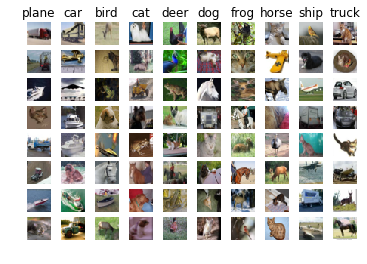

In [20]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ They seem to be clustered by color, which would make sense for any image classifier, but more so for data binned by color.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [21]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [62]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """

    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        # Unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, _ = X.shape

        # Compute the forward pass
        scores = None
        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        layer_1 = X@W1+b1
        acts_1 = relu(layer_1)
        scores = acts_1@W2+b2

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # If the targets are not given then jump out, we're done
        if y is None:
            return scores

        # Compute the loss
        loss = None
        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        
        smax = softmax(scores)
        loss = np.mean(-np.log(smax[range(N),y]))
        loss += reg * (np.sum(W1*W1)+np.sum(W2*W2))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # Backward pass: compute gradients
        grads = {}
        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        smax[range(N),y]-=1
        smax/=N

        grads["W2"] = acts_1.T@smax
        grads["b2"] = np.sum(smax,0)
        dl1 = smax@W2.T * (layer_1>0)
        grads["W1"] = X.T@dl1
        grads["b1"] = np.sum(dl1,0)

        grads["W1"] += reg * 2 * W1
        grads["W2"] += reg * 2 * W2

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return loss, grads

    def train(self, X, y, X_val, y_val,
              learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this neural network using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
          after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train // batch_size, 1)

        # Use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            indices = np.random.choice(range(num_train),batch_size, True)
            X_batch = X[indices]
            y_batch = y[indices]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            for param in self.params:
              self.params[param] -= learning_rate*grads[param]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

            # Every epoch, check train and val accuracy and decay learning rate.
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        """
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
        - X: A numpy array of shape (N, D) giving N D-dimensional data points to
          classify.

        Returns:
        - y_pred: A numpy array of shape (N,) giving predicted labels for each of
          the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
          to have class c, where 0 <= c < C.
        """
        y_pred = None

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        y_pred = np.argmax(self.loss(X),1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

def relu(X):
  return (abs(X) + X) / 2

def softmax(X):
  f = X - np.max(X,1,keepdims=True)
  exp = np.exp(f)
  return exp/np.sum(exp,1,keepdims=True)

In [63]:
input_dim = X_train_feats.shape[1]
hidden_dim = 512
num_classes = 10

best_acc = -1
best_hyp = {}
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

accs_val = {}
accs_train = {}
gridsearch = [(lr,rs,hd) for lr in np.logspace(-1,0,3) \
                         for rs in np.logspace(-8,-5,3) \
                         for hd in [512,1024]]

for lr,rs,hd in gridsearch:
    net = TwoLayerNet(input_dim, hd, num_classes)
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=1000, batch_size=4076,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=rs, verbose=False)
    acc_val = stats["val_acc_history"][-1]
    acc_train = stats["train_acc_history"][-1]
    accs_val[(lr,rs,hd)] = acc_val
    accs_train[(lr,rs,hd)] = acc_train
    print(lr,rs,hd,acc_train,acc_val)
    if acc_val > best_acc:
        best_acc = acc_val
        best_net = net
        best_hyp["lr"] = lr
        best_hyp["rs"] = rs
        best_hyp["hd"] = hd

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


0.1 1e-08 512 0.25883218842001965 0.279
0.1 1e-08 1024 0.2794406280667321 0.288
0.1 3.162277660168379e-07 512 0.26251226692836116 0.286
0.1 3.162277660168379e-07 1024 0.27919528949950934 0.287
0.1 1e-05 512 0.2522080471050049 0.283
0.1 1e-05 1024 0.2634936211972522 0.278
0.31622776601683794 1e-08 512 0.5058881256133464 0.499
0.31622776601683794 1e-08 1024 0.5184003925417076 0.501
0.31622776601683794 3.162277660168379e-07 512 0.5049067713444554 0.5
0.31622776601683794 3.162277660168379e-07 1024 0.5291952894995093 0.507
0.31622776601683794 1e-05 512 0.5208537782139352 0.504
0.31622776601683794 1e-05 1024 0.5174190382728164 0.508
1.0 1e-08 512 0.6010794896957802 0.573
1.0 1e-08 1024 0.6018155053974484 0.573
1.0 3.162277660168379e-07 512 0.5907752698724239 0.565
1.0 3.162277660168379e-07 1024 0.5947006869479883 0.571
1.0 1e-05 512 0.592737978410206 0.562
1.0 1e-05 1024 0.6025515210991168 0.567
Validation accuracy:  0.566


In [64]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.562


---
# IMPORTANT

This is the end of this question. Please do the following:

1. Click `File -> Save` to make sure the latest checkpoint of this notebook is saved to your Drive.
2. Execute the cell below to download the modified `.py` files back to your drive.

In [ ]:
import os

FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
FILES_TO_SAVE = []

for files in FILES_TO_SAVE:
  with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
    f.write(''.join(open(files).readlines()))